### En el caso del Emcee es similar al metropolis pero no es como tal un metropolis, es un método de montecarlo, pero a diferencia de mcmc en este caso todos los caminadores son independientes.

In [1]:
def linea(x,m,b):
    return m*x+b

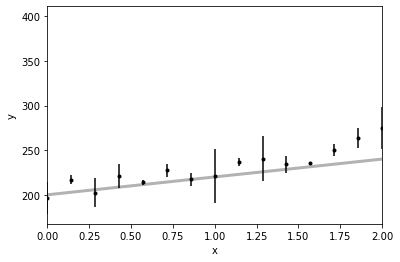

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = 20
b_true = 200
f_true = 0.534
#aquí se generan los datos sinteticos, entonces aquí sería donde cargaríamos nuestros datos.

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

#ejemplo
arr = np.load('test_line.npy')
x= arr[0]
y= arr[1]
yerr=arr[2]

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = 19.339 ± 2.411
b = 206.785 ± 3.165


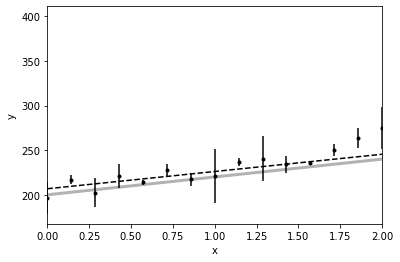

In [26]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
#plt.legend(f2)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [9]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 22.483
b = 205.969
f = 0.018


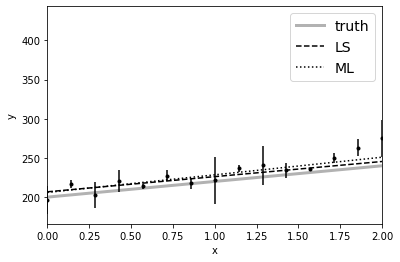

In [20]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [21]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0 #es lo mismo de que devolver la diferencia de las constatnes
    return -np.inf

In [22]:
def log_probability(theta, x, y, yerr): #este es el posterior
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [13]:
import emcee
#lo de abajo podría inicializarce el soln.x en pos_ini=[50,200]
pos = soln.x + 1e-4 * np.random.randn(32, 3) #soln.x es la minimización de -likelihood que es el chi sqr
#tambiem podría definir yo cuantos caminadores quiero y cuandas dimensiones o parametros libres.
nwalkers, ndim = pos.shape
#pero lo podemos definir en cualquier otro punto y en principio podríamos definirlo en cualqueir otro punto de partida
#emcee es fácil que se quede en máximos locales
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/valdiviagcr/miniconda3/envs/ambiente1/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:05<00:00, 950.55it/s] 


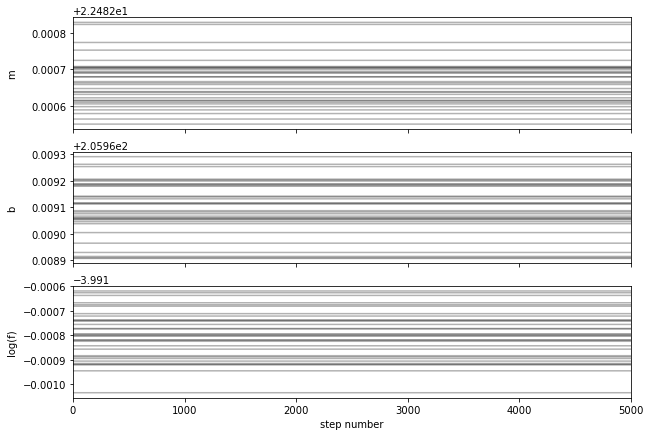

In [14]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
tau = sampler.get_autocorr_time() #el sampler contiene las cadenas
print(tau)

[nan nan nan]


/Users/valdiviagcr/miniconda3/envs/ambiente1/lib/python3.7/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


In [16]:
sampler.get_chain?

Signature: sampler.get_chain(**kwargs)
Docstring:
Get the stored chain of MCMC samples

Args:
    flat (Optional[bool]): Flatten the chain across the ensemble.
        (default: ``False``)
    thin (Optional[int]): Take only every ``thin`` steps from the
        chain. (default: ``1``)
    discard (Optional[int]): Discard the first ``discard`` steps in
        the chain as burn-in. (default: ``0``)

Returns:
    array[..., nwalkers, ndim]: The MCMC samples.
File:      ~/miniconda3/envs/ambiente1/lib/python3.7/site-packages/emcee/ensemble.py
Type:      method


In [17]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


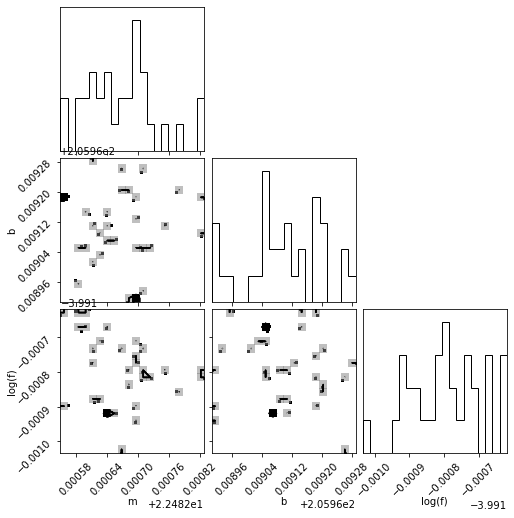

In [18]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

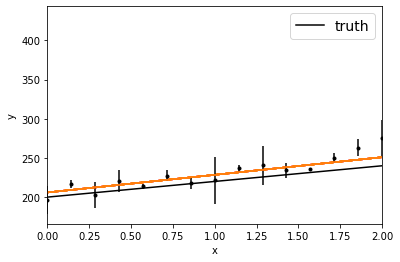

In [23]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))